In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
def plot_image(image, title=None):
    if title:
        plt.title(title, size=16)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def plot_grid_images(images):
    n_images = len(images)
    fig = plt.figure(figsize=(n_images * 1.5, 2))
    for img_idx in range(n_images):
        plt.subplot(2, n_images, 1 + img_idx)
        plot_image(images[img_idx], img_idx)

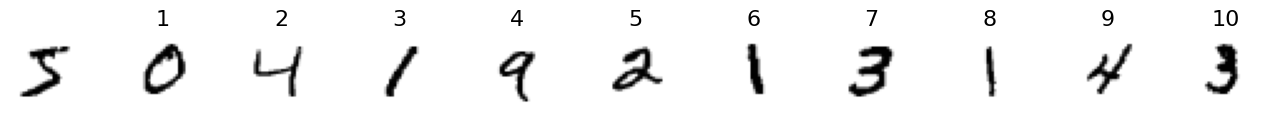

In [5]:
plot_grid_images(X_train_full[:11])

In [6]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

custom_objects = {'Sampling': Sampling}

In [7]:
'''

Pre-trained models - Instructions about training you can find in another file

'''

model_name = 'regular_MNIST_vae'
if model_name == 'regular_MNIST_vae':
    variational_ae = keras.models.load_model('regular_MNIST_vae/autoencoder/vae_autoencoder.keras', custom_objects=custom_objects)
    variational_encoder = keras.models.load_model('regular_MNIST_vae/encoder/vae_encoder.keras', custom_objects=custom_objects)
    variational_decoder = keras.models.load_model('regular_MNIST_vae/decoder/vae_decoder.keras', custom_objects=custom_objects)
elif model_name == 'high_z_vae':
    variational_ae = keras.models.load_model('high_z_vae/variational_ae.h5', custom_objects=custom_objects)
    variational_encoder = keras.models.load_model('high_z_vae/variational_encoder.h5', custom_objects=custom_objects)
    variational_decoder = keras.models.load_model('high_z_vae/variational_decoder.h5', custom_objects=custom_objects)
elif model_name == 'Resnet_Like_MNIST_vae':
    variational_ae = keras.models.load_model('Resnet_Like_MNIST_vae/autoencoder/vae_autoencoder.tf', custom_objects=custom_objects)
    variational_encoder = keras.models.load_model('Resnet_Like_MNIST_vae/encoder/vae_encoder.tf', custom_objects=custom_objects)
    variational_decoder = keras.models.load_model('Resnet_Like_MNIST_vae/decoder/vae_decoder.tf', custom_objects=custom_objects)

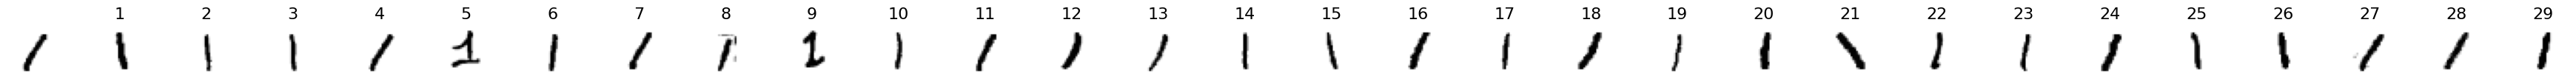

In [8]:
plot_grid_images(X_train_full[y_train_full == 1][:30])

In [9]:
list_slope_1 = [0, 4, 7, 18, 27, 28]

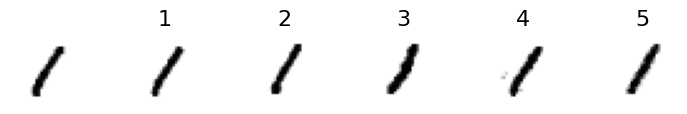

In [10]:
plot_grid_images(X_train_full[y_train_full == 1][list_slope_1])

In [11]:
_, _, X_slope_1_encoded = variational_encoder(X_train_full[y_train_full == 1][list_slope_1].reshape(-1, 28, 28, 1))

In [12]:
X_slope_1_encoded.numpy().shape

(6, 16)

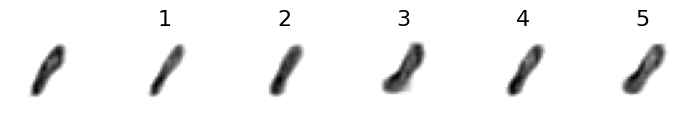

In [13]:
plot_grid_images(variational_decoder(X_slope_1_encoded).numpy())

In [14]:
centroid_slope_1 = X_slope_1_encoded.numpy().mean(axis=0).reshape(1, -1)
centroid_1 = variational_encoder(X_train_full[y_train_full == 1].reshape(-1, 28, 28, 1))[2].numpy().mean(axis=0).reshape(1, -1)
att_slope_1 = centroid_slope_1 - centroid_1

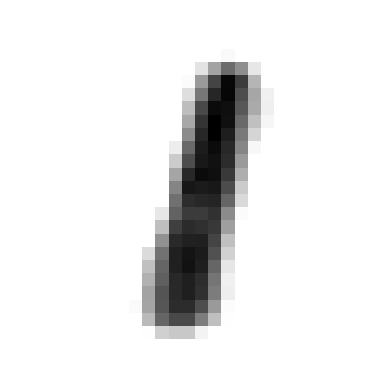

In [15]:
plot_image(variational_decoder(centroid_1).numpy().reshape(28, 28))

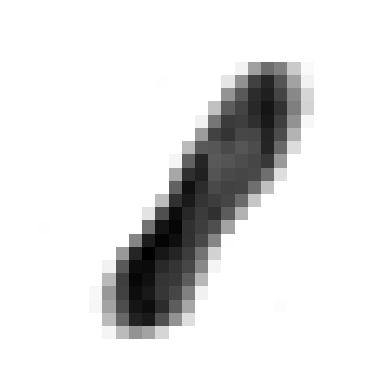

In [16]:
plot_image(variational_decoder(centroid_slope_1).numpy().reshape(28, 28))

In [17]:
samples = 20
A, B = centroid_slope_1, centroid_1
versor = (B - A) / np.linalg.norm(B - A)
d = np.linspace(0, np.linalg.norm(B - A), samples)
interpolated_points = A + d.reshape(-1, 1) * versor * 1.2

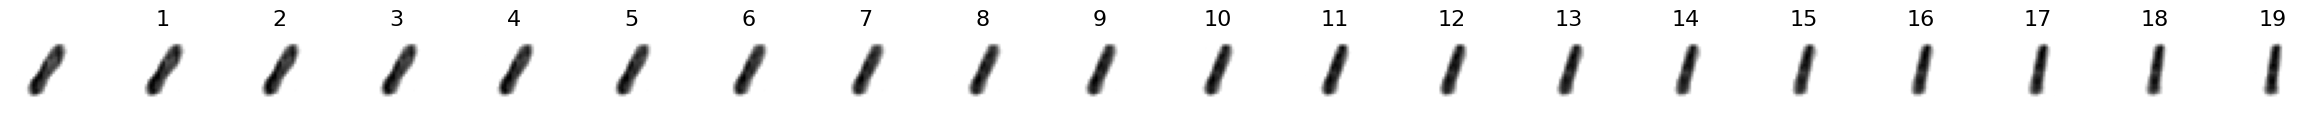

In [18]:
# Mudança da inclinação
plot_grid_images(variational_decoder(interpolated_points).numpy())

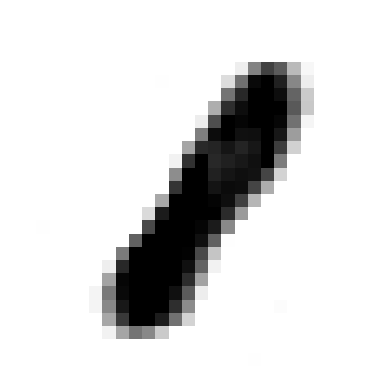

In [19]:
plot_image(np.clip((variational_decoder(interpolated_points[0].reshape(1, -1)).numpy() * 255).astype(int).reshape(28, 28), 0, 255))

In [27]:
import gradio as gr
import os


def image_classifier(value):
    return np.clip((variational_decoder(interpolated_points[value].reshape(1, -1)).numpy() * 255).astype(int).reshape(28, 28), 0, 255)

input_value_d = gr.Slider(minimum=0, maximum=19, default=0, step=1)
demo = gr.Interface(fn=image_classifier, inputs=input_value_d, outputs="image", live=True)

if __name__ == "__main__":
    demo.launch(server_port=501, debug=True, server_name='localhost')

C:\Users\gabri\AppData\Local\Temp\ipykernel_30192\1712859968.py:8: GradioUnusedKwargWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  input_value_d = gr.Slider(minimum=0, maximum=19, default=0, step=1)


Running on local URL:  http://localhost:501

To create a public link, set `share=True` in `launch()`.


## Interpolation Between Classes


In [20]:
def get_center_of_mass(df):
    cms = []
    labels = df.label.unique()
    for label in sorted(labels):
        cm = df[df.label == label][df.columns[:-1]].sum() / df[df.label == label].shape[0]
        cms.append(cm.values)
    return cms

In [22]:
_, _, X_test_encoded = variational_encoder(X_test.reshape(-1, 28, 28, 1))

In [24]:
df = pd.concat([pd.DataFrame(X_test_encoded), pd.DataFrame(y_test, columns=['label'])], axis=1)

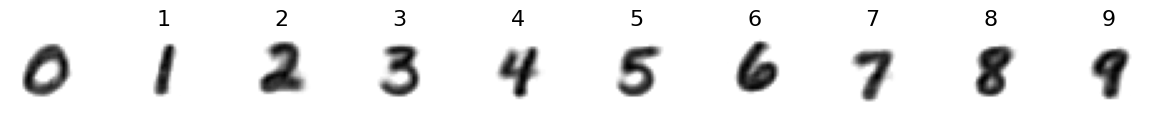

In [26]:
cms = get_center_of_mass(df)
imgs_cm = [np.clip(variational_decoder(cms[i].reshape(1, -1))[0], 0.0, 255.0) for i in range(10)]
plot_grid_images(imgs_cm)

In [27]:
many = []
for i in range(10):#range(4, len(cms) - 5):
    A, B = cms[i - 1].copy(), cms[i].copy()
    versor = (B - A) / np.linalg.norm(B - A)
    d = np.linspace(0, np.linalg.norm(B - A), 100)
    for i in range(100):
        row = A + d[i] * versor
        many.append(row.copy())

many = tf.convert_to_tensor(tf.squeeze(np.array(many)))
images = variational_decoder(many).numpy()
images_converted = []

for x in images:
    new_x = ((x - x.min()) / (x - x.min()).max()) * 255
    new_x = new_x.astype(np.uint8)
    images_converted.append(new_x)

images_converted = np.array(images_converted)
# np.array([(img * 255).astype(np.int32) for img in images])

In [30]:
many.numpy().shape

(1000, 16)

In [59]:
aux = np.clip(((variational_decoder(many[0].numpy().reshape(1, -1))[0]) * 255), 0, 255).astype(int)[:, :, 0]
aux.min(), aux.max(), aux.shape

(0, 255, (28, 28))

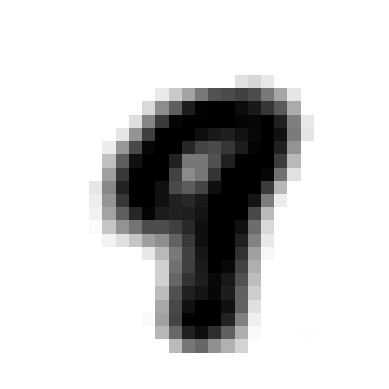

In [55]:
plot_image(aux)

In [67]:
import gradio as gr
import os


def image_classifier(value):
    return np.clip(((variational_decoder(many[(value * 5) + 100].numpy().reshape(1, -1))[0]) * 255), 0, 255).astype(int)[:, :, 0]

input_value_d = gr.Slider(minimum=0, maximum=175, default=0, step=1)
demo = gr.Interface(fn=image_classifier, inputs=input_value_d, outputs="image", live=True)

if __name__ == "__main__":
    demo.launch(server_port=501, debug=True, server_name='localhost')

C:\Users\gabri\AppData\Local\Temp\ipykernel_17856\2129939135.py:8: GradioUnusedKwargWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  input_value_d = gr.Slider(minimum=0, maximum=175, default=0, step=1)


Running on local URL:  http://localhost:501

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
